In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [27]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-particle_stats_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
X = result[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
print result.columns


Index([u'fsc_avg', u'fsc_var', u'chl_avg', u'chl_var', u'pe_avg', u'pe_var', u'Cruise', u'Day', u'File_Id'], dtype='object')


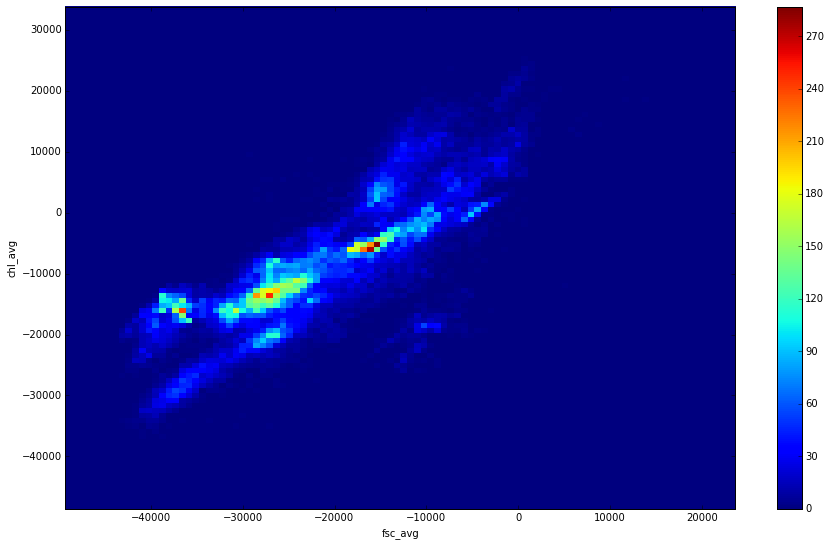

In [3]:
# plot the data to see if it seems to fall into particular clusters right off the bat

fig1 = plt.figure(1, figsize=(15,9))
plt.hist2d(result['fsc_avg'],result['chl_avg'],bins=100, cmap='jet')
plt.xlabel('fsc_avg')
plt.ylabel('chl_avg')
plt.colorbar()
plt.show()

Reduced dataset shape: (47155, 2)


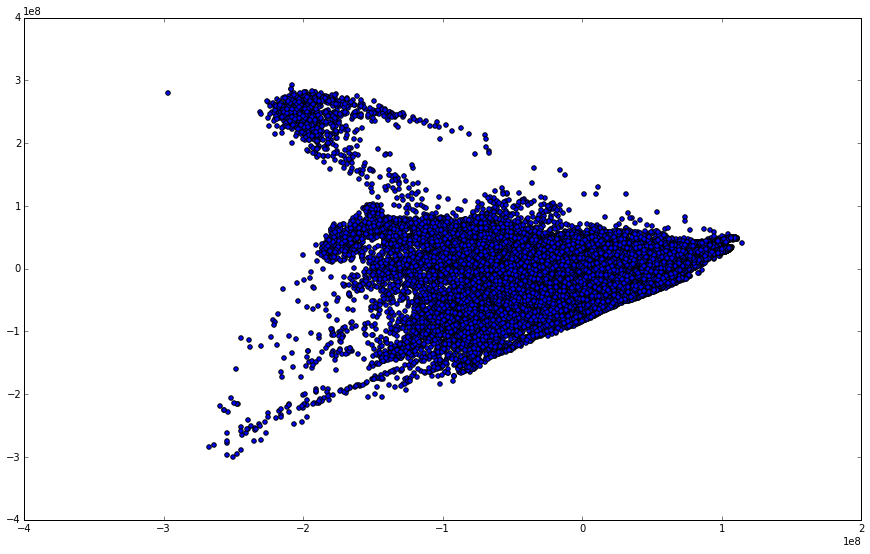

In [4]:
# try doing PCA on the particle statistics
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print "Reduced dataset shape:", X_reduced.shape

fig2 = plt.figure(2, figsize=(15,9))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.show()

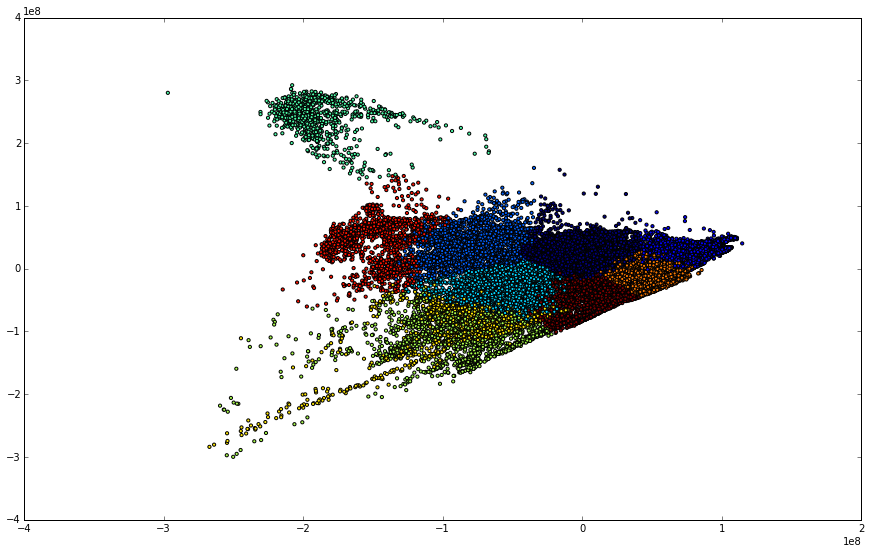

In [5]:
# now try some kind of clustering. 
# start with K-means
k_means = KMeans(n_clusters=10, random_state=0)
k_means.fit(X)
y_pred = k_means.predict(X)

fig3 = plt.figure(3, figsize=(15,9))
plt.scatter(X_reduced[:,0],X_reduced[:,1],s=10,c=y_pred)
plt.show()

In [6]:
result['group']=y_pred

print result[['Cruise','group']]
#print len(pd.unique(result['Cruise']))

            Cruise  group
0       Thompson_4      2
1       Thompson_8      6
2      Thompson_12      1
3          Tokyo_2      7
4          Tokyo_2      9
5          Tokyo_4      0
6          MBARI_2      0
7          MBARI_2      0
8          MBARI_2      0
9       Thompson_0      9
10      Thompson_9      7
11      Thompson_9      7
12      Thompson_1      6
13     Thompson_10      0
14     Thompson_10      0
15     Thompson_10      0
16     Thompson_11      8
17         Tokyo_1      7
18         Tokyo_2      1
19         Tokyo_2      7
20         Tokyo_3      5
21         Tokyo_4      7
22         Tokyo_4      7
23         MBARI_1      7
24      Thompson_1      5
25      Thompson_4      1
26      Thompson_8      7
27      Thompson_4      7
28      Thompson_4      1
29      Thompson_1      6
...            ...    ...
47125   Thompson_9      7
47126  Thompson_10      0
47127      Tokyo_3      5
47128      Tokyo_3      0
47129      Tokyo_4      0
47130      MBARI_1      7
47131       

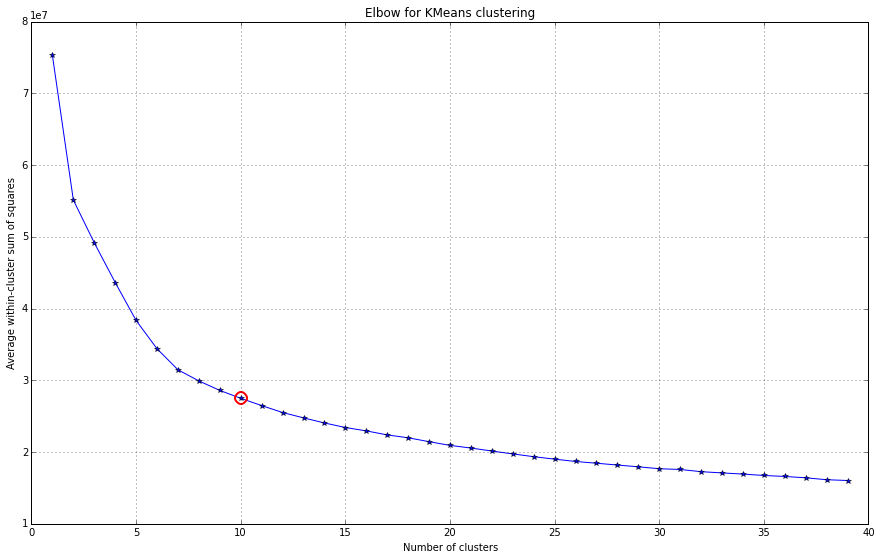

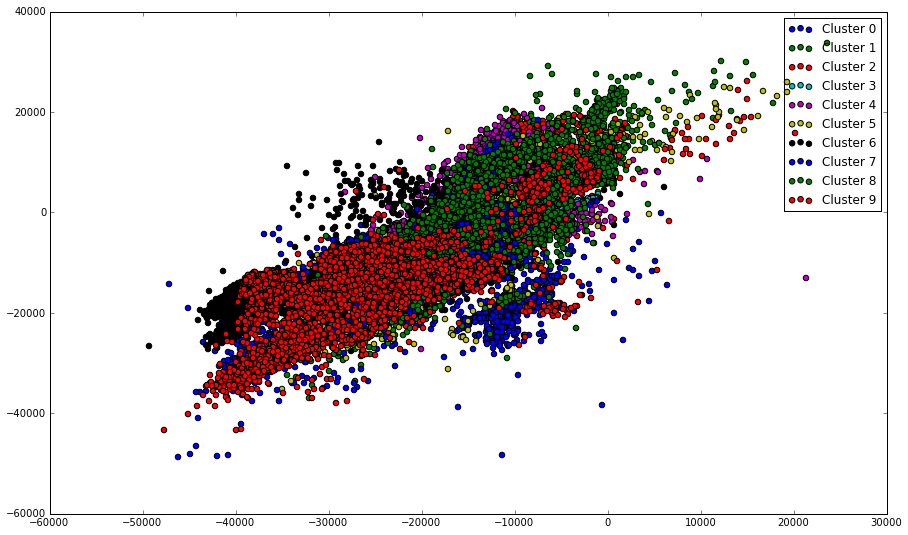

In [7]:
# try hierarchical clustering on the data
# do not have to specify number of clusters

from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

# Start by estimating optimal number of clusters
# uses method from this website: 
# http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means
K = range(1,40)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 9

# elbow curve
fig4 = plt.figure(4, figsize=(15,9))
ax = fig4.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig5 = plt.figure(5, figsize=(15,9))
ax = fig5.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k','b','g','r']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X[ind,0],X[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
plt.legend()
plt.show()

In [20]:
print cIdx[9].max()



9


In [28]:
# load in the SDS data so that we can look at clusters in T/S space and "real" space
# also want to get seasons/months of year for each file

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
print sds.columns

# get seasons and join to the sds dataframe
# Get month from the yearday in the file_id\n",
day = (sds['day']).tolist()

yd = []

for n in range(0,len(day)):
    yd.append(day[n].split("_")[1])
yd = np.asarray(yd)
yd = yd.astype(np.int)
                           
# length of months
mlen = (31,28,31,30,31,30,31,31,30,31,30,31)
cmlen = np.cumsum(mlen)

month = []
for n in range(0,len(day)):
    if yd[n]<=cmlen[0]:
        month.append(1)
    if yd[n]>cmlen[0] and yd[n]<=cmlen[1]:
        month.append(2)
    if yd[n]>cmlen[1] and yd[n]<=cmlen[2]:
        month.append(3)
    if yd[n]>cmlen[2] and yd[n]<=cmlen[3]: 
        month.append(4)
    if yd[n]>cmlen[3] and yd[n]<=cmlen[4]: 
        month.append(5)
    if yd[n]>cmlen[4] and yd[n]<=cmlen[5]: 
        month.append(6)
    if yd[n]>cmlen[5] and yd[n]<=cmlen[6]:
        month.append(7)
    if yd[n]>cmlen[6] and yd[n]<=cmlen[7]: 
        month.append(8)
    if yd[n]>cmlen[7] and yd[n]<=cmlen[8]:
        month.append(9)
    if yd[n]>cmlen[8] and yd[n]<=cmlen[9]:
        month.append(10)
    if yd[n]>cmlen[9] and yd[n]<=cmlen[10]:
        month.append(11)
    if yd[n]>cmlen[10] and yd[n]<=cmlen[11]: 
        month.append(12)

sds['month'] = month

Index([u'day', u'LAT', u'LON', u'file', u'T', u'S', u'Cruise'], dtype='object')


In [29]:
# join sds dataframe to cluster results

print sds.shape
#print type(sds), type(cIdx[9])
new_table = pd.merge(sds, result, join='inner')

(69235, 8)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"